In [205]:
from random import random
from random import seed
seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [321]:
# Config
MFRAC = 0.5
EPOCH = 6000
# Initial guess
ni = np.array([0.00027, 4.0, 0.063, 1.215, 0.145])
delta_n = np.array([0.0001, 0.001, 0.0001, 0.0001, 0.0001])
# Mutation step
mutation = np.array([0.09, 0.09, 0.09, 0.09, 0.09])
mutation_decay = 1e-4

In [198]:
# Read data
ydata = pd.read_csv("./data/data1.csv")

ND = ydata.shape[0]        #number of data vectors in array
DI = ydata.shape[1]        #number of data items in vector
NS = ND                    #total number of DNA strands

# log
lydata = ydata.copy()
lydata = np.log(lydata + 1e-12)


In [335]:
# Functions needed
# Initialize n
def initialize(ni, delta_n):
    # Initializing n
    n = np.array([(ni + [random() for i in range(DI)] * delta_n) for i in range(ND)] )  # 45x5 randomized initial value
    return n
    
# Relative Absolute Error
def AFERR(n, lydata):
    Ferr = -lydata["HeatFlux"] + np.log(n[:, 0]) + n[:, 1] * lydata["Superheat"] + n[:, 2] * lydata["g"]
    aFerr = np.abs(Ferr) / np.abs(lydata["HeatFlux"])
    return aFerr

# Error and Selection
def selection(n, lydata, MFRAC=MFRAC):
    # Error calculation
    aFerr = AFERR(n, lydata)
    aFerrMean = np.mean(aFerr)
    aFerrMedian = np.median(aFerr)
    
    # Sorting
    sorted_id = np.argsort(aFerr)
    aFerr[:] = aFerr[sorted_id]
    sorted_n[:] = n[sorted_id]
    
    # Selection
    clim = MFRAC * aFerrMedian
    nkeep = np.searchsorted(aFerr, clim)
    return sorted_n, nkeep

# Mating
def mating(sorted_n, nkeep, mutation, mutation_decay, epoch=0):
    if nkeep == sorted_n.shape[0]:
        print("EPOCH %d: NOT MATING"%(epoch))
        return sorted_n
    
    for row in sorted_n[nkeep:, :]:
        # Randomly choose 2 parents
        parents = [sorted_n[np.random.randint(0, nkeep+1)] for i in range(2)]
        
        # Choose which parent to inherit from
        # inherit[i] = 0 or 1
        inherit = [np.random.randint(0, 2) for i in range(DI)]
        r = [parents[inherit[i]][i] for i in range(DI)]
        
        # Mutation
        mut_rate = [(2*(0.5-np.random.rand())) for i in range(DI)]
        row[:] = r * (1 + mut_rate * mutation)
        if mutation_decay:
            mutation[:] = mutation * (1-mutation_decay)
    return sorted_n
        
# Train
def train(EPOCH=300, ni=ni, delta_n=delta_n, MFRAC=MFRAC, mutation=mutation, mutation_decay=0):
    n = initialize(ni, delta_n)
    n_means, aFerr_means = [], []
    n_best = np.array([0.0 for i in range(DI)])
    aFerr_min, best_epoch = 1, 0

    for epoch in range(EPOCH):
        sorted_n, nkeep = selection(n, lydata, MFRAC)
        n = mating(sorted_n, nkeep, mutation, mutation_decay, epoch)
        # statistic features
        n_mean = np.mean(n, axis=0)
        aFerr_mean = np.mean(AFERR(n_mean.reshape(1,-1), lydata))

        n_means.append(n_mean)
        aFerr_means.append(aFerr_mean)
        if aFerr_mean < aFerr_min:
            aFerr_min = aFerr_mean
            n_best[:] = n_mean
            best_epoch = epoch

    # Result
    print("ENDING: n1: %f, n2: %f, n3: %f, aFerrmean: %f" %(n_mean[0], n_mean[1], n_mean[2], aFerr_mean))
    print("OPTIM: n1: %f, n2: %f, n3: %f, aFerrmean: %f, BestEpoch: %d" %(n_best[0], n_best[1], n_best[2], aFerr_min, best_epoch))
    return n_means, aFerr_means, n_best, aFerr_min, best_epoch    

# Plotting
def const_error(n_means, aFerr_means, i=-1, sub=111):
    n_means = np.array(n_means)
    x = range(n_means.shape[0])
    # Plotting
    plt.subplot(sub)
    if i >= 0:
        plt.title("Initial Guess: {}\nMutation Magnitude: {}".format(nis[i], mutations[i]))
    plt.xlabel("Epochs")
    plt.ylabel("Constants and Error")
    plt.plot(x, n_means[:, 0], label="n1")
    plt.plot(x, n_means[:, 1], label="n2")
    plt.plot(x, n_means[:, 2], label="n3")
    plt.plot(x, aFerr_means, label="aFerr")
    plt.legend()
    plt.loglog()
    
def pred_true(n, sub=111):
    # Calculating y_pred
    n = n.reshape(1,-1)
    y_pred = np.log(n[:, 0]) + n[:, 1] * lydata["Superheat"] + n[:, 2] * lydata["g"]
    # Plotting
    plt.subplot(sub)
    plt.scatter(y_pred, lydata["HeatFlux"])


In [329]:
# Main
# optimal: 0.0007726, 3.188, 0.05206
nis = [
    np.array([0.00027, 4.0, 0.063, 0, 0]),
    np.array([0.003, 10, 1, 0, 0]),
    np.array([1, 20, 5, 0, 0]),
    np.array([2, 100, 20, 0, 0])
]
mutations = [
    np.array([0.09 for i in range(DI)]),
    np.array([0.2 for i in range(DI)]),    # doesn't converge for 0.09
    np.array([0.5 for i in range(DI)]),
    np.array([0.8 for i in range(DI)])
]

results = []
for i in range(4):
    res = train(EPOCH, nis[i], delta_n, MFRAC, mutations[i])
    results.append(res)


ENDING: n1: 0.000532, n2: 3.297251, n3: 0.056204, aFerrmean: 0.030412
OPTIM: n1: 0.000663, n2: 3.231332, n3: 0.054983, aFerrmean: 0.029782, BestEpoch: 5747
ENDING: n1: 0.001055, n2: 3.111988, n3: 0.018702, aFerrmean: 0.034923
OPTIM: n1: 0.001706, n2: 2.974315, n3: 0.040939, aFerrmean: 0.028734, BestEpoch: 4787
ENDING: n1: 0.002224, n2: 2.974629, n3: 0.002250, aFerrmean: 0.061918
OPTIM: n1: 0.001209, n2: 3.060302, n3: 0.031275, aFerrmean: 0.029743, BestEpoch: 376
ENDING: n1: 0.000741, n2: 3.473701, n3: 0.000001, aFerrmean: 0.213939
OPTIM: n1: 0.004644, n2: 2.688922, n3: 0.005216, aFerrmean: 0.032634, BestEpoch: 196


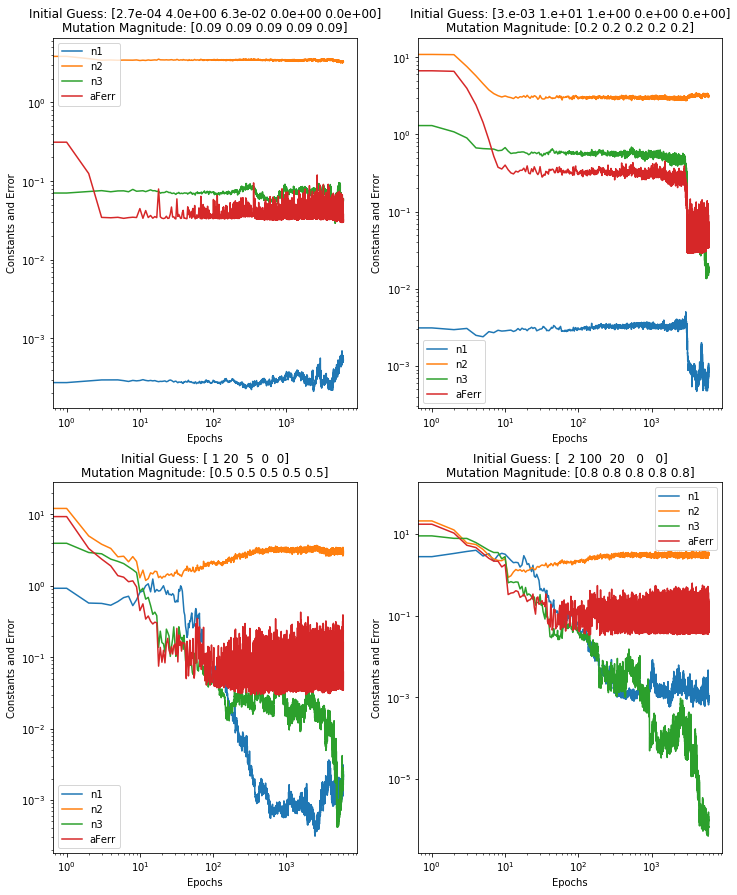

In [330]:
# Plotting
plt.figure(figsize=(12,15))
for (i, (n_means, aFerr_means, n_best, aFerr_min, best_epoch)) in enumerate(results):
    const_error(n_means, aFerr_means, i, 221+i)
plt.savefig("./result/const_and_error.png")

ENDING: n1: 157.933024, n2: 0.000000, n3: 0.000000, aFerrmean: 0.121226
OPTIM: n1: 96.701815, n2: 0.000017, n3: 0.020719, aFerrmean: 0.095762, BestEpoch: 61


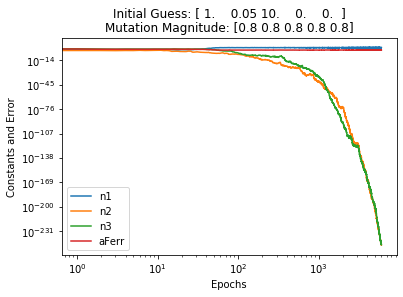

In [337]:
# Bad initial value case
# May never converge
ni = np.array([1, 0.05, 10, 0, 0])
mutation = np.array([0.8 for i in range(DI)])
n_means, aFerr_means, n_best, aFerr_min, best_epoch = train(EPOCH, ni, delta_n, MFRAC, mutation)
const_error(n_means, aFerr_means)
plt.title("Initial Guess: {}\nMutation Magnitude: {}".format(ni, mutation))
plt.savefig("./result/const_and_error_slope.png")

In [ ]:
# pred_true(n_best)
# plt.show()

In [ ]:
"""
np.array([1, 0.05, 10, 0, 0])
"""